# Project in Introduction to Computational Statistics

## Contributors:

| | Lastname | Firstname | Matriculation Number|
| --- | ------------------ | ------------------ | -------------------- |
| 1 | Kürnsteiner | David | |
| 2 | Peinthor | Christian | |
| 3 | Ramoser | Elias | |
| 4 | Storz | Georg | k11918811 |

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
df1 = pd.read_excel('Project Data.xlsx', 'LOMA LARGA')
df2 = pd.read_excel('Project Data.xlsx', '2 NORTE')
df3 = pd.read_excel('Project Data.xlsx', 'ALMENDRAL')
df4 = pd.read_excel('Project Data.xlsx', 'CORDILLERA')

In [62]:
rename_dict_spa = {'Concentración (copias/mL)': 'concentration', 'Tasa incidencia activos': 'active_incidence', 'Tasa incidencia actual': 'current_incidence', 'Casos activos': 'active_cases', 'Casos actuales': 'actual_cases'}
rename_dict_eng = {'Concentration ': 'concentration', 'Active Incidence Rate ': 'active_incidence', 'Actual Incidence Rate': 'current_incidence', 'Active Cases': 'active_cases', 'Actual Cases': 'actual_cases'}
df1 = df1[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df1 = df1.rename(columns=rename_dict_spa)
df2 = df2[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df2 = df2.rename(columns=rename_dict_spa)
df3 = df3[['Concentración (copias/mL)', 'Tasa incidencia activos', 'Tasa incidencia actual', 'Casos activos', 'Casos actuales']]
df3 = df3.rename(columns=rename_dict_spa)
df4 = df4[['Concentration ', 'Active Incidence Rate ', 'Actual Incidence Rate', 'Active Cases', 'Actual Cases']]
df4 = df4.rename(columns=rename_dict_eng)

In [146]:
def make_lin_reg(X_col, Y_col, X_name, Y_name):
    fig, axs = plt.subplots(2,2, figsize=(15, 6))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = .5, wspace=.5)
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,1,2,3]):
        X = df[X_col].to_numpy()
        Y = df[Y_col].to_numpy()
        lm = np.polyfit(X, Y, 1)
        predict = np.poly1d(lm)
        new_x = np.linspace(min(X), max(X))
        new_y = predict(new_x)
        axs[index].scatter(X, Y)
        axs[index].plot(new_x, new_y, color='red')
        axs[index].set_title(name)
        axs[index].set_xlabel(X_name)
        axs[index].set_ylabel(Y_name)
    plt.show()
    

def make_non_lin_reg(X_col, Y_col, X_name, Y_name, degrees):
    for df, name in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA']):
        print(f'\nNon-linear Regressions with the data: {name}')
        X = df[X_col].to_numpy()
        Y = df[Y_col].to_numpy()
        fig, axs = plt.subplots(2,2, figsize=(15, 6))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)

        for index, deg in enumerate(degrees):
            lm = np.polyfit(X, Y, deg)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[index].scatter(X, Y)
            axs[index].plot(new_x, new_y, color='red')
            axs[index].set_title(name + f' (Degree: {deg})')
            axs[index].set_xlabel(X_name)
            axs[index].set_ylabel(Y_name)
        plt.show()
        

def replace_dep(X_col_before, X_col_after, Y_col, X_col_name_before, X_col_name_after, Y_col_name):
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,2,4,6]):
        dep_var = [X_col_before, X_col_after]
        label_name = [X_col_name_before, X_col_name_after]
        fig, axs = plt.subplots(1,2, figsize=(10, 4))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)
        for i in [0,1]:
            X = df[dep_var[i]].to_numpy()
            Y = df[Y_col].to_numpy()
            lm = np.polyfit(X, Y, 1)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[i].scatter(X, Y)
            axs[i].plot(new_x, new_y, color='red')
            axs[i].set_title(name + f' ({label_name[i]})')
            axs[i].set_xlabel(label_name[i])
            axs[i].set_ylabel(Y_col_name)

        plt.show()
    
        
def replace_indep(X_col, Y_col_before, Y_col_after, X_col_name, Y_col_name_before, Y_col_name_after):
    for df, name, index in zip([df1, df2, df3, df4], ['LOMA LARGA', '2 NORTE', 'ALMENDRAL', 'CORDILLERA'], [0,2,4,6]):
        indep_var = [Y_col_before, Y_col_after]
        label_name = [Y_col_name_before, Y_col_name_after]
        fig, axs = plt.subplots(1,2, figsize=(10, 4))
        axs = axs.ravel()
        fig.subplots_adjust(hspace = .5, wspace=.5)
        for i in [0,1]:
            X = df[X_col].to_numpy()
            Y = df[dep_var[i]].to_numpy()
            lm = np.polyfit(X, Y, 1)
            predict = np.poly1d(lm)
            new_x = np.linspace(min(X), max(X))
            new_y = predict(new_x)
            axs[i].scatter(X, Y)
            axs[i].plot(new_x, new_y, color='red')
            axs[i].set_title(name + f' ({label_name[i]})')
            axs[i].set_xlabel(X_col_name)
            axs[i].set_ylabel(label_name[i])

        plt.show()

## Task 1
- Check the collinearity of CurrentIncidenceRate and ActualCases.
- Check the collinearity of ActiveIncidenceRate and ActiveCases.

In [63]:
df1.corr()

,concentration,active_incidence,current_incidence,active_cases,actual_cases
concentration,1.000000,-0.198572,-0.197320,-0.198508,-0.197131
active_incidence,-0.198572,1.000000,0.999933,1.000000,0.999931
current_incidence,-0.197320,0.999933,1.000000,0.999936,1.000000
active_cases,-0.198508,1.000000,0.999936,1.000000,0.999934
actual_cases,-0.197131,0.999931,1.000000,0.999934,1.000000


Above we can see the correlation of the variables. The range of the values is from -1 to 1 (from not to highly correlated).

Collinearity of CurrentIncidenceRate and ActualCases:   
From above we can conclude that these two variables are highly correlated (value: 1) and therefore they are collinear!
   
Collinearity of ActiveIncidenceRate and ActiveCases:   
Here we have same situation as above with exactly the same value (1). So we can conclude that also these two variables are collinear.

## Task 2   
Study the dependence of: $~~~~~~~~~~$ Concentration = $f_1$(ActiveCases)   
- First make linear regression   
- Is the linear regression plausible? If not, suggest a non linear regression.   
- Would quality of linear regression increase, if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate"?   
- Make a comparison between plausible models.   
- Are residuals normally distributed?   
- Are there outliers?    
- Would adding of more secondary variables lead to a significantly improved regression?

#### Make a linear Regression

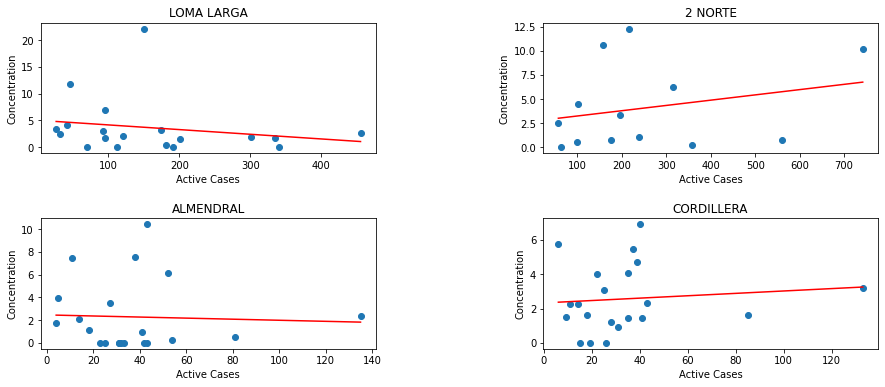

In [137]:
make_lin_reg('active_cases', 'concentration', 'Active Cases', 'Concentration')

---------------- Interpretation -------------

#### Make non-linear regressions


Non-linear Regressions with the data: LOMA LARGA


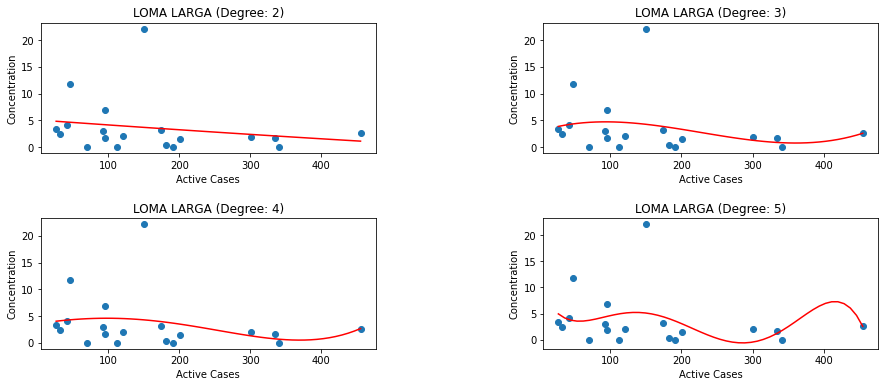


Non-linear Regressions with the data: 2 NORTE


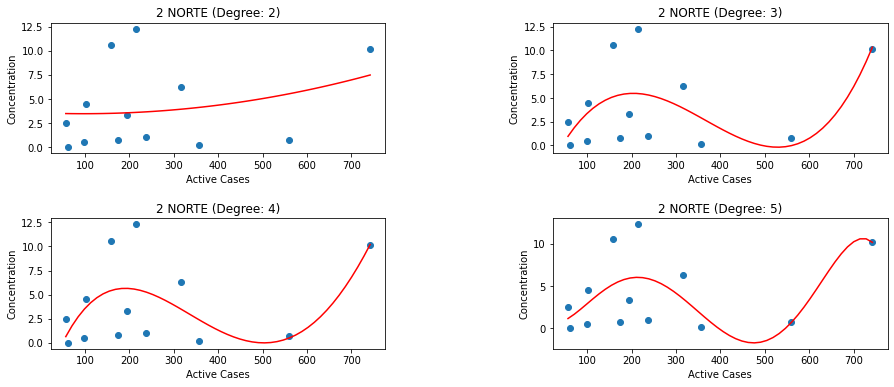


Non-linear Regressions with the data: ALMENDRAL


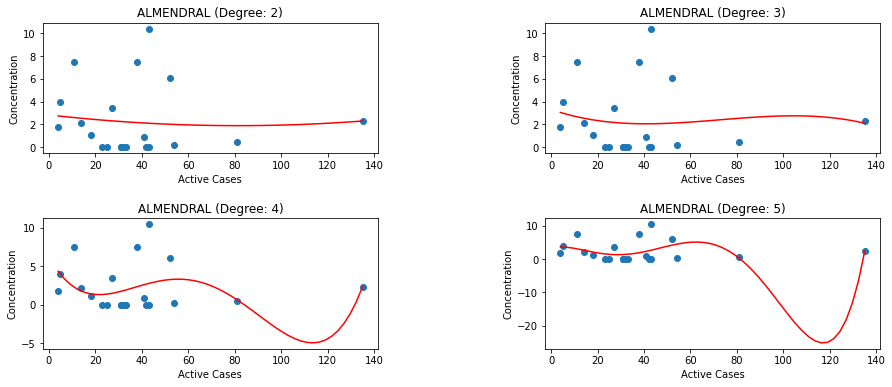


Non-linear Regressions with the data: CORDILLERA


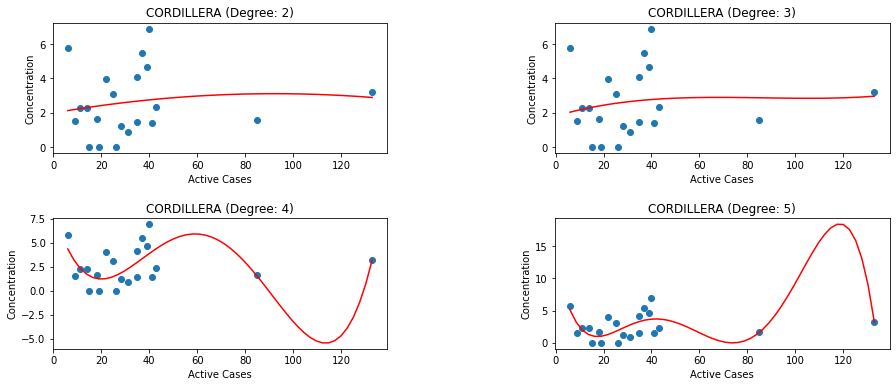

In [140]:
make_non_lin_reg('active_cases', 'concentration', 'Active Cases', 'Concentration', [2,3,4,5])

-------------------------- Interpretation what is plausible ----------------------

#### Would quality of linear regression increase, if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate"?

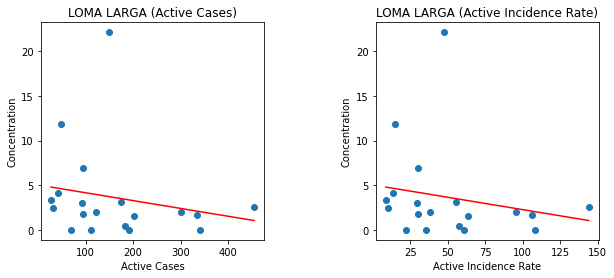

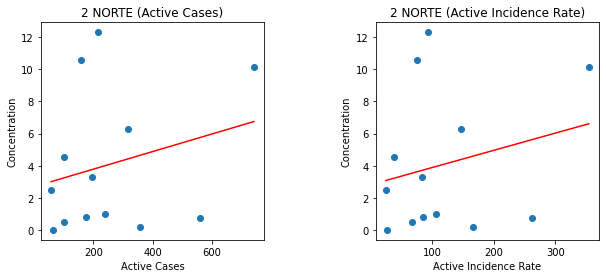

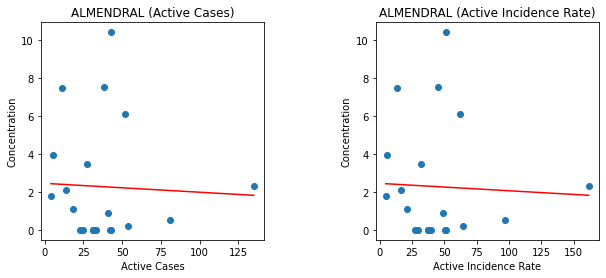

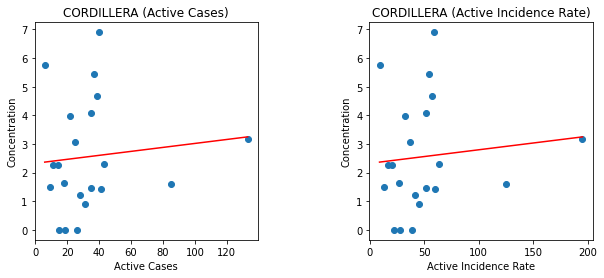

In [147]:
replace_dep('active_cases', 'active_incidence', 'concentration', 'Active Cases', 'Active Incidence Rate', 'Concentration')

In this side to side comparisons we see that the quality would not increase if we replace dependent variable "ActiveCases" by variable "ActiveIncidenceRate".

#### Make a comparison between plausible models

#### Are residuals normally distributed?

#### Are there outliers?

#### Would adding of more secondary variables lead to a significantly improved regression?

## Task 3   
Study the dependence of: $~~~~~~~~~~$ ActiveCases = $f_1$(Concentration)   
- First make linear regression   
- Is the linear regression plausible? If not, suggest a non linear regression.   
- Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActiveIncidenceRate"? 
- Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActualCases"? 
- Make a comparison between plausible models.   
- Are residuals normally distributed?   
- Are there outliers?    
- Would adding of more secondary variables lead to a significantly improved regression?

#### Make a linear Regression

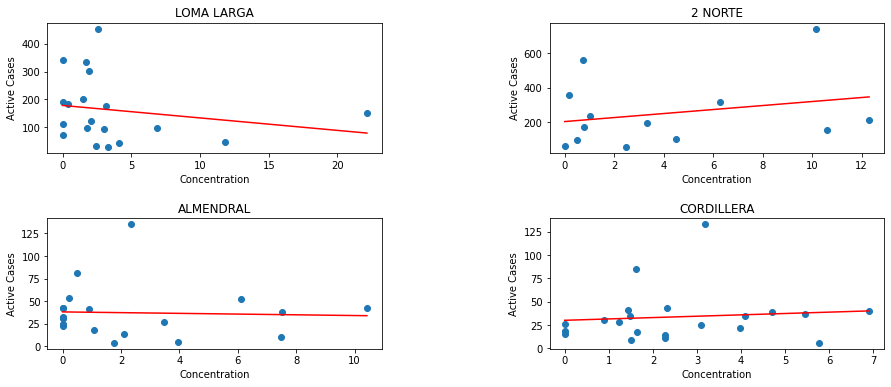

In [138]:
make_lin_reg('concentration', 'active_cases', 'Concentration', 'Active Cases')

----------------- interpretation -----------------

#### Make non-linear regressions


Non-linear Regressions with the data: LOMA LARGA


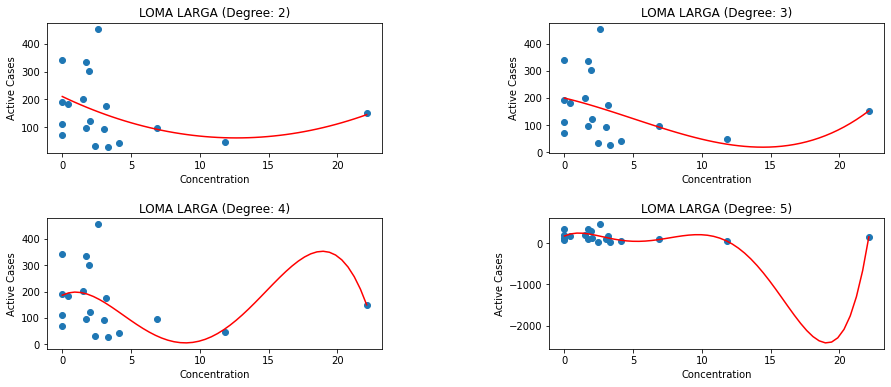


Non-linear Regressions with the data: 2 NORTE


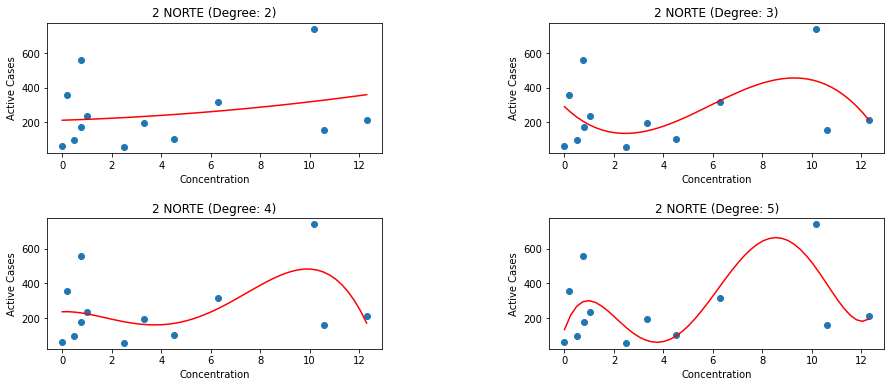


Non-linear Regressions with the data: ALMENDRAL


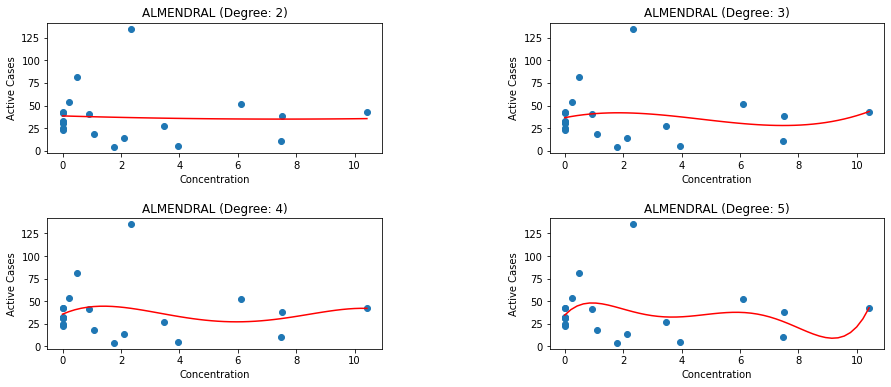


Non-linear Regressions with the data: CORDILLERA


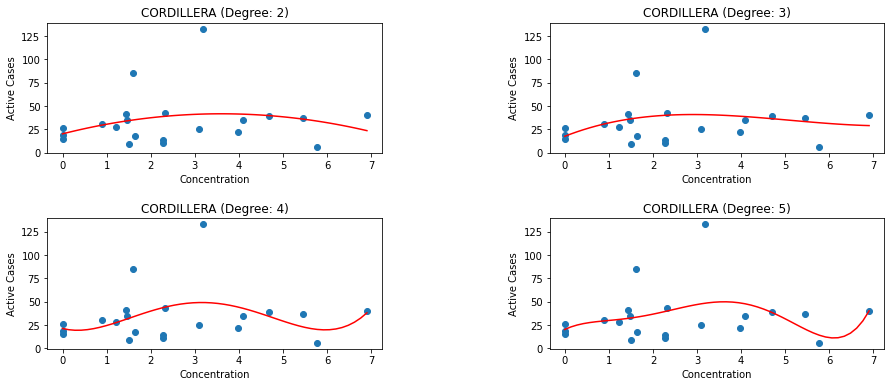

In [141]:
make_non_lin_reg( 'concentration', 'active_cases', 'Concentration', 'Active Cases', [2,3,4,5])

------------------- interpretation ----------------------

#### Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActiveIncidenceRate"? 

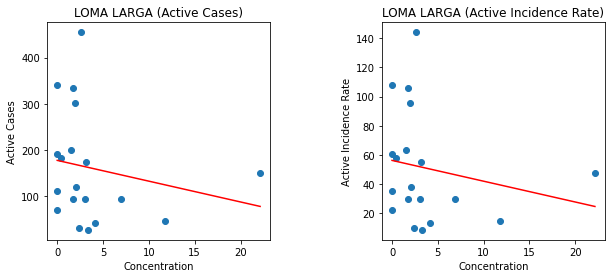

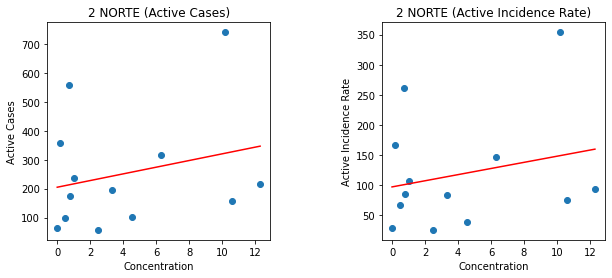

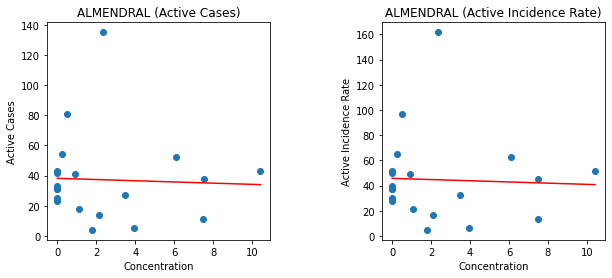

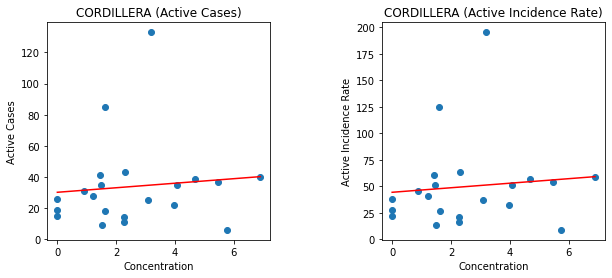

In [144]:
replace_indep('concentration', 'active_cases', 'active_incidence', 'Concentration', 'Active Cases', 'Active Incidence Rate')

At first the plots beside each other look identical but there is a difference in the y-axis. This difference leads also to different squared losses of the models and therefore to a better or worse fit.  
   
For the datasets CORDILLERA and ALMENDRAL we have a worse fit if we replace the independent variable 'ActiveCases' with the variable 'ActiveIncidenceRate'.   
   
For the datasets LOMA LARGA and 2 NORTE we have a better fit if we replace the independent variable 'ActiveCases' with the variable 'ActiveIncidenceRate'.

#### Would quality of linear regression increase, if we replace independent variable "ActiveCases" by variable "ActualCases"?

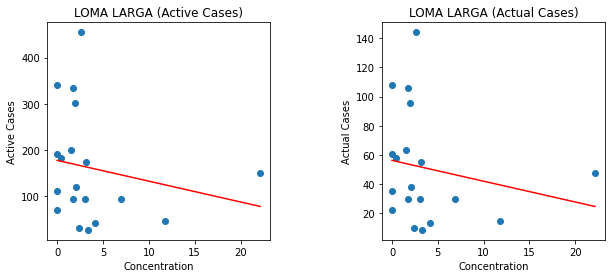

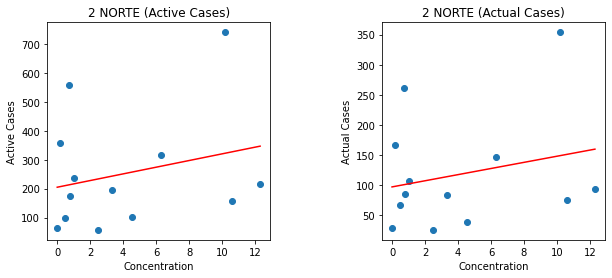

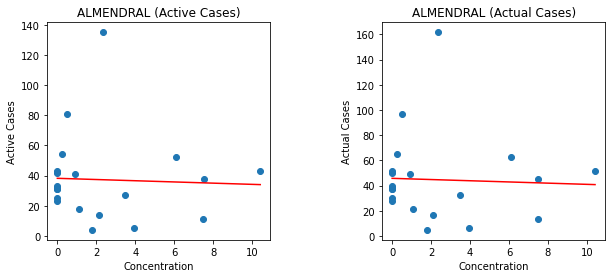

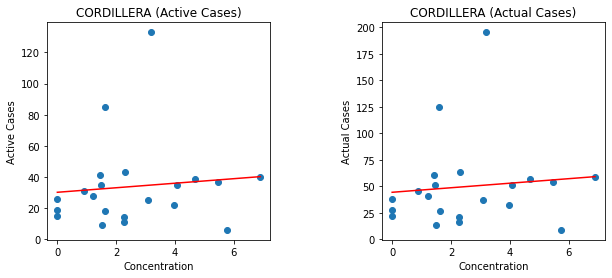

In [148]:
replace_indep('concentration', 'active_cases', 'actual_cases', 'Concentration', 'Active Cases', 'Actual Cases')